In [23]:
# functions for reading and writing TFW files
# AFG1k, AFG2k, AFG3ks

# TFW files are a simplistic binary
# they only contain shape data
# amplitude, offset, and timing are applied at run-time by AFG settings

# https://www.tek.com/sample-license

import struct
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class TFW_Read_Error(Exception):
    """general error for TFW file operations"""
    pass

def read_tfw(target):
    """open target file and return numpy array of digital dac values"""
    with open(target, 'rb') as f:
        h = f.read(512)
        if len(h) != 512:
            raise TFW_Read_Error('file too small')
        m = struct.unpack_from('>10s6x3I', h)
        if m[0] != b'TEKAFG3000':
            raise TFW_Read_Error('missing TFW identifier "TEKAFG3000"')
        if m[1] != 20050114:
            raise TFW_Read_Error('version not 20050114')
        samples = m[2]
        dac_values = np.fromfile(f, dtype='>u2', count=samples)
    return dac_values

def normal_vector(vector, ymax=16382, ymin=0, dtype='>u2'):
    """normalize vector to integer values between ymin and ymax"""
    m = (ymax - ymin) / (vector.max() - vector.min())
    b = ymax - (m * vector.max())
    n = m * vector + b
    n = np.array(n, dtype=dtype)
    return n

def envelope_vector(dac_values):
    """return envelope vector from dac_values"""
    # envelope is maximum 206 uint8 min-max pairs
    n = np.array(dac_values >> 6, dtype=np.uint8)
    if len(dac_values) <= 206:
        upper = n
        lower = n
    else:
        segments = np.array_split(n, 206)
        upper = np.zeros(206, dtype=np.uint8)
        lower = np.zeros(206, dtype=np.uint8)
        for i, s in enumerate(segments):
            upper[i] = s.max()
            lower[i] = s.min()
    c = np.vstack((lower, upper)).reshape(-1, order='F')
    return c

def write_tfw(target, dac_values):
    """write target file in TFW format with dac_values"""
    d = np.array((dac_values & 0x3fff), dtype='>u2') # cast and mask
    samples = len(d)
    # an envelope vector is used for arb plot on AFG
    envelope = envelope_vector(d)
    header = bytearray(512)
    struct.pack_into('>10s6x3I',    # format
                     header,        # buffer
                     0,             # offset
                     b'TEKAFG3000', # magic bytes
                     20050114,      # version
                     samples,       # length
                     1)             # envelope flag
    header[28:28+len(envelope)] = memoryview(envelope)
    with open(target, 'wb') as f:
        f.write(header)
        f.write(memoryview(d))

def write_tfw_no_envelope(target, dac_values):
    """write target file in TFW format with dac_values omitting envelope"""
    d = np.array((dac_values & 0x3fff), dtype='>u2') # cast and mask
    samples = len(d)
    header = bytearray(512)
    struct.pack_into('>10s6x3I',    # format
                     header,        # buffer
                     0,             # offset
                     b'TEKAFG3000', # magic bytes
                     20050114,      # version
                     samples,       # length
                     0)             # envelope flag
    with open(target, 'wb') as f:
        f.write(header)
        f.write(memoryview(d))

In [25]:
file = 'example.tfw'
samples = 10000
t = np.arange(1, samples, dtype=np.uint16)
y = np.sin(2 * np.pi * t / samples * 20) + np.sin(2 * np.pi * t / samples * 50) + np.sin(2 * np.pi * t / samples * 8)
n = normal_vector(y)
# print(n)
write_tfw(file, n)

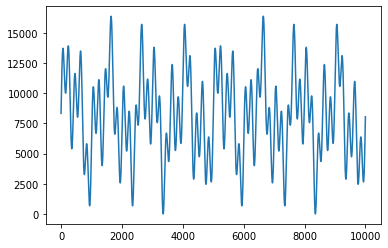

In [26]:
plt.plot(t, n)